In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import joblib

In [2]:
# Load the data
def load_file(file_path):
    return np.loadtxt(file_path)

# List of file paths
file_paths = [
    r"/root/raman raw data/updated_Kont_D16_ZT6_2H_401_238.txt",
    r"/root/raman raw data/updated_Kont_D16_ZT6_8H_467_178.txt",
    r"/root/raman raw data/updated_Kont_D16_ZT6_16H.txt",
    r"/root/raman raw data/updated_SRBG_D16_ZT6_7H_445_176.txt",
    r"/root/raman raw data/updated_SRBG_ZT6_D16_3H_445_264.txt",
    r"/root/raman raw data/updated_SRBG_D16_ZT6_6H.txt"
]

loaded_images = Parallel(n_jobs=-1)(delayed(load_file)(file_path) for file_path in file_paths)

cont_image1, cont_image2, cont_image3, srbg_image1, srbg_image2, srbg_image3 = loaded_images

38.32495069503784

In [3]:
# Reshape them as y,x,z
cont_image1 = cont_image1.reshape(401,238,1000)
cont_image2 = cont_image2.reshape(467,178,1000)
cont_image3 = cont_image3.reshape(277,601,1000)
srbg_image1 = srbg_image1.reshape(445,176,1000)
srbg_image2 = srbg_image2.reshape(445,264,1000)
srbg_image3 = srbg_image3.reshape(396,334,1000)

In [10]:
images = [srbg_image1, srbg_image2, srbg_image3, cont_image1, cont_image2, cont_image3]

In [11]:
# Outlier Elimination
def percentile_outlier_to_zero_3d_nonzero(images, lower_percentile, upper_percentile):
    processed_images = []
    eliminated_spectra_per_image = []  
    eliminated_locations_per_image = [] 
    
    for image in images:
        nonzero_mask = np.any(image != 0, axis=-1)
        
        lower_bound = np.percentile(image[nonzero_mask], lower_percentile, axis=0, keepdims=True)
        upper_bound = np.percentile(image[nonzero_mask], upper_percentile, axis=0, keepdims=True)
        
        outlier_mask = (image < lower_bound) | (image > upper_bound)
        
        processed_image = np.copy(image)
        
        mask_for_outliers_in_nonzero_vectors = np.any(outlier_mask & nonzero_mask[..., np.newaxis], axis=-1)
        
        processed_image[mask_for_outliers_in_nonzero_vectors] = 0
        
        eliminated_spectra = np.sum(mask_for_outliers_in_nonzero_vectors)
        eliminated_spectra_per_image.append(eliminated_spectra)
        
        eliminated_locations = np.argwhere(mask_for_outliers_in_nonzero_vectors)
        eliminated_locations_per_image.append(eliminated_locations)
        
        processed_images.append(processed_image)
    
    return processed_images, eliminated_spectra_per_image, eliminated_locations_per_image

In [12]:
processed_images, eliminated_spectra_per_image, eliminated_locations_per_image = percentile_outlier_to_zero_3d_nonzero(images,
                                                                    lower_percentile=0.003, upper_percentile=99.997)

In [17]:
for i, (eliminated_spectra, eliminated_locations) in enumerate(zip(eliminated_spectra_per_image, eliminated_locations_per_image)):
    print(f"Image {i+1}: Number of spectra where outliers were eliminated: {eliminated_spectra}")
    print(f"Image {i+1}: Locations of eliminated spectra: {eliminated_locations}")

Image 1: Number of spectra where outliers were eliminated: 953
Image 1: Locations of eliminated spectra: [[  0  42]
 [  0  64]
 [  0  79]
 ...
 [441 112]
 [442 111]
 [444 102]]
Image 2: Number of spectra where outliers were eliminated: 1163
Image 2: Locations of eliminated spectra: [[  0  95]
 [  0 117]
 [  0 158]
 ...
 [443 229]
 [444 143]
 [444 259]]
Image 3: Number of spectra where outliers were eliminated: 819
Image 3: Locations of eliminated spectra: [[  0 190]
 [  0 223]
 [  0 236]
 ...
 [393 176]
 [394 172]
 [395 209]]
Image 4: Number of spectra where outliers were eliminated: 1054
Image 4: Locations of eliminated spectra: [[  0 123]
 [  0 196]
 [  1 103]
 ...
 [400  37]
 [400 193]
 [400 204]]
Image 5: Number of spectra where outliers were eliminated: 772
Image 5: Locations of eliminated spectra: [[ 93  92]
 [ 94  86]
 [ 94  94]
 ...
 [466  79]
 [466 106]
 [466 156]]
Image 6: Number of spectra where outliers were eliminated: 1491
Image 6: Locations of eliminated spectra: [[  0 1

In [13]:
# Take only the tissue spectra
for i,data in enumerate(processed_images):
    mask = np.any(data != 0, axis=-1)
    filtered_data = data[mask]
    globals()["filtered_data_" + str(i)] = filtered_data.reshape(-1, data.shape[-1])

In [24]:
# Classification
srbg_images=np.concatenate([filtered_data_0,filtered_data_1,filtered_data_2])
cont_images=np.concatenate([filtered_data_3,filtered_data_4,filtered_data_5])

In [25]:
x=np.arange(800,1800)
srbg_mean=np.mean(srbg_images,axis=0)
srbg_std=np.std(srbg_images,axis=0)
cont_mean=np.mean(cont_images,axis=0)
cont_std=np.std(cont_images,axis=0)

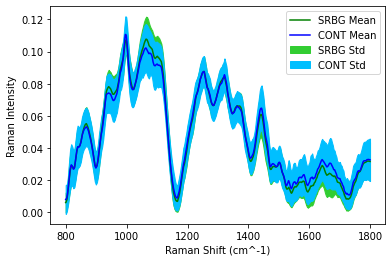

In [26]:
# Spectra
plt.plot(x,srbg_mean,'g',label='SRBG Mean')
plt.plot(x,cont_mean,'b',label='CONT Mean')
plt.fill_between(x, srbg_mean - srbg_std, srbg_mean + srbg_std, color='limegreen',label='SRBG Std')
plt.fill_between(x, cont_mean - cont_std, cont_mean + cont_std, color='deepskyblue',label='CONT Std')
plt.xlabel('Raman Shift (cm^-1)')
plt.ylabel('Raman Intensity')

plt.legend()
plt.show()

In [27]:
difference = srbg_mean-cont_mean
peaks, _ = find_peaks(difference)
deeps, _ = find_peaks(-difference)

In [39]:
filtered_peaks = [peak for peak in peaks if difference[peak] > 0.005]
filtered_deeps = [deep for deep in deeps if difference[deep] < -0.005]

In [45]:
filtered_deeps

[803, 809, 854, 857, 868, 870]

In [41]:
filtered_peaks

[268, 287]

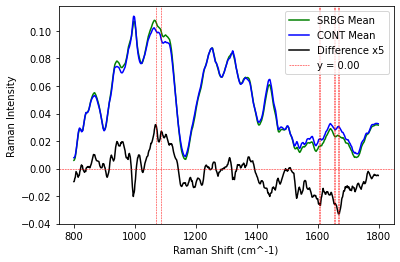

In [42]:
# Mean spectra and the most different points
plt.plot(x,srbg_mean,'g',label='SRBG Mean')
plt.plot(x,cont_mean,'b',label='CONT Mean')
plt.plot(x,5*(srbg_mean-cont_mean),'black',label="Difference x5")
plt.axhline(y=0.00,color='red',linestyle='--',label='y = 0.00',linewidth=0.5)

for peak in filtered_peaks:
    plt.axvline(x=x[peak],color='red',linestyle='--',linewidth=0.5)
for deep in filtered_deeps:
    plt.axvline(x=x[deep],color='red', linestyle='--',linewidth=0.5)
    
plt.xlabel('Raman Shift (cm^-1)')
plt.ylabel('Raman Intensity')

plt.legend()
plt.show()

In [50]:
# Mann-Whitney U test
n_wavenumbers = 1000

p_values = []

for i in range(n_wavenumbers):
    srbg_wavenumber = srbg_images[:, i]
    cont_wavenumber = cont_images[:, i]
    
    stat, p_value = mannwhitneyu(srbg_wavenumber, cont_wavenumber, alternative='two-sided', method='asymptotic')    
    p_values.append(p_value)

In [57]:
p_values = np.array(p_values)

adjusted_p_values = multipletests(p_values, alpha=0.001, method='bonferroni')

corrected_p_values = adjusted_p_values[1]
significant_wavenumbers = np.where(adjusted_p_values[0])[0]

for wavenumber in significant_wavenumbers:
    print(f"Wavenumber {800 + wavenumber}: corrected p-value = {corrected_p_values[wavenumber]} (significant)")

Wavenumber 800: corrected p-value = 0.0 (significant)
Wavenumber 801: corrected p-value = 0.0 (significant)
Wavenumber 802: corrected p-value = 9.637354659874348e-258 (significant)
Wavenumber 803: corrected p-value = 3.59909315316574e-105 (significant)
Wavenumber 804: corrected p-value = 8.906414879416537e-94 (significant)
Wavenumber 805: corrected p-value = 2.87369774270399e-42 (significant)
Wavenumber 807: corrected p-value = 6.700408613846816e-12 (significant)
Wavenumber 810: corrected p-value = 0.0008079373039104054 (significant)
Wavenumber 811: corrected p-value = 1.1473048101358557e-12 (significant)
Wavenumber 812: corrected p-value = 1.1513889252569955e-36 (significant)
Wavenumber 813: corrected p-value = 3.4643770081452457e-70 (significant)
Wavenumber 814: corrected p-value = 8.388065793199096e-107 (significant)
Wavenumber 815: corrected p-value = 7.303793924141007e-78 (significant)
Wavenumber 816: corrected p-value = 1.1918875732578463e-79 (significant)
Wavenumber 817: correct

In [58]:
significant_wavenumbers.shape

(928,)

In [48]:
# DataFrame for easier plotting with seaborn
# Most significant Raman shift values
df = pd.DataFrame({
    'value': np.concatenate([cont_images[:,268], srbg_images[:,268],
                            cont_images[:,287], srbg_images[:,287],
                            cont_images[:,803], srbg_images[:,803],
                            cont_images[:,854], srbg_images[:,854],
                            cont_images[:,868], srbg_images[:,868]]),
    'group': ['1068 cm^-1'] * len(cont_images[:,268]) + ['1068 cm^-1'] * len(srbg_images[:,268]) + 
             ['1087 cm^-1'] * len(cont_images[:,287]) + ['1087 cm^-1'] * len(srbg_images[:,287]) +
             ['1603 cm^-1'] * len(cont_images[:,803]) + ['1603 cm^-1'] * len(srbg_images[:,803]) +
             ['1654 cm^-1'] * len(cont_images[:,854]) + ['1654 cm^-1'] * len(srbg_images[:,854]) +
             ['1668 cm^-1'] * len(cont_images[:,868]) + ['1668 cm^-1'] * len(srbg_images[:,868]),
                             
    'status': ['CONT'] * len(cont_images[:,268]) + ['SRBG'] * len(srbg_images[:,268]) + 
              ['CONT'] * len(cont_images[:,287]) + ['SRBG'] * len(srbg_images[:,287]) +
              ['CONT'] * len(cont_images[:,803]) + ['SRBG'] * len(srbg_images[:,803]) +
              ['CONT'] * len(cont_images[:,854]) + ['SRBG'] * len(srbg_images[:,854]) +
              ['CONT'] * len(cont_images[:,868]) + ['SRBG'] * len(srbg_images[:,868])
})

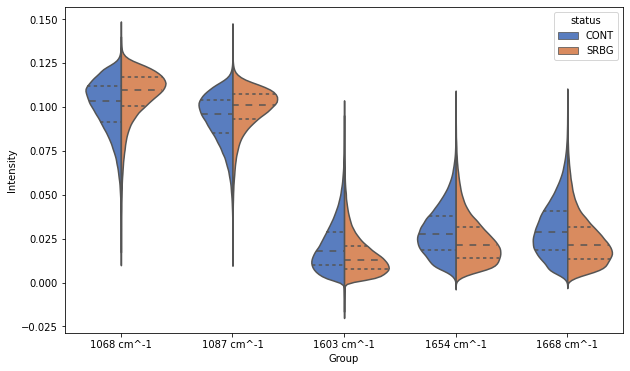

In [49]:
# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='group', y='value', hue='status', data=df, split=True, inner="quartile", palette="muted")
plt.xlabel('Group')
plt.ylabel('Intensity')
plt.show()

In [14]:
# Equalize the shapes of all the contributions
def resize_image(image, target_rows, random_state=None):
    rng = np.random.RandomState(random_state)
    
    indices_to_keep = rng.choice(image.shape[0], target_rows, replace=False)
    
    indices_to_keep.sort()
    
    return image[indices_to_keep]

target_rows = min([filtered_data_0.shape[0], filtered_data_1.shape[0], filtered_data_2.shape[0],
                   filtered_data_3.shape[0], filtered_data_4.shape[0], filtered_data_5.shape[0]])

random_state = 29

image0_resized = resize_image(filtered_data_0, target_rows, random_state=random_state)
image1_resized = resize_image(filtered_data_1, target_rows, random_state=random_state)
image2_resized = resize_image(filtered_data_2, target_rows, random_state=random_state)
image3_resized = resize_image(filtered_data_3, target_rows, random_state=random_state)
image4_resized = resize_image(filtered_data_4, target_rows, random_state=random_state)
image5_resized = resize_image(filtered_data_5, target_rows, random_state=random_state)

(42237, 1000)
(42237, 1000)
(42237, 1000)
(42237, 1000)
(42237, 1000)
(42237, 1000)


In [15]:
images=np.concatenate((image0_resized,image1_resized,image2_resized,image3_resized,image4_resized,image5_resized))

In [16]:
# Labels: 0 for control, 1 for pathologic
srbg_labels = np.ones(int(images.shape[0]/2))
cont_labels = np.zeros(int(images.shape[0]/2))

In [17]:
labels = np.concatenate((srbg_labels,cont_labels))

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=57)

In [63]:
# Pretrained XGBoost Model
xgb_model = xgb.XGBClassifier(
    max_depth=4,
    learning_rate=0.01,
    n_estimators=1000,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=10,           
    reg_alpha=2,             
    min_child_weight=7,     
    eval_metric='logloss'
)

# Fit the XGBoost model on training data with validation for early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[0]	validation_0-logloss:0.69238
[1]	validation_0-logloss:0.69163
[2]	validation_0-logloss:0.69085
[3]	validation_0-logloss:0.69009
[4]	validation_0-logloss:0.68934
[5]	validation_0-logloss:0.68863
[6]	validation_0-logloss:0.68791
[7]	validation_0-logloss:0.68720
[8]	validation_0-logloss:0.68652
[9]	validation_0-logloss:0.68582
[10]	validation_0-logloss:0.68514
[11]	validation_0-logloss:0.68448
[12]	validation_0-logloss:0.68385
[13]	validation_0-logloss:0.68320
[14]	validation_0-logloss:0.68257
[15]	validation_0-logloss:0.68196
[16]	validation_0-logloss:0.68135
[17]	validation_0-logloss:0.68075
[18]	validation_0-logloss:0.68015
[19]	validation_0-logloss:0.67956
[20]	validation_0-logloss:0.67898
[21]	validation_0-logloss:0.67842
[22]	validation_0-logloss:0.67787
[23]	validation_0-logloss:0.67730
[24]	validation_0-logloss:0.67675
[25]	validation_0-logloss:0.67622
[26]	validation_0-logloss:0.67570
[27]	validation_0-logloss:0.67519
[28]	validation_0-logloss:0.67468
[29]	validation_0-loglos

[238]	validation_0-logloss:0.62831
[239]	validation_0-logloss:0.62818
[240]	validation_0-logloss:0.62809
[241]	validation_0-logloss:0.62798
[242]	validation_0-logloss:0.62789
[243]	validation_0-logloss:0.62779
[244]	validation_0-logloss:0.62769
[245]	validation_0-logloss:0.62758
[246]	validation_0-logloss:0.62751
[247]	validation_0-logloss:0.62739
[248]	validation_0-logloss:0.62729
[249]	validation_0-logloss:0.62718
[250]	validation_0-logloss:0.62708
[251]	validation_0-logloss:0.62698
[252]	validation_0-logloss:0.62687
[253]	validation_0-logloss:0.62676
[254]	validation_0-logloss:0.62667
[255]	validation_0-logloss:0.62656
[256]	validation_0-logloss:0.62647
[257]	validation_0-logloss:0.62637
[258]	validation_0-logloss:0.62628
[259]	validation_0-logloss:0.62618
[260]	validation_0-logloss:0.62608
[261]	validation_0-logloss:0.62599
[262]	validation_0-logloss:0.62590
[263]	validation_0-logloss:0.62581
[264]	validation_0-logloss:0.62572
[265]	validation_0-logloss:0.62564
[266]	validation_0-l

[473]	validation_0-logloss:0.61111
[474]	validation_0-logloss:0.61106
[475]	validation_0-logloss:0.61100
[476]	validation_0-logloss:0.61095
[477]	validation_0-logloss:0.61089
[478]	validation_0-logloss:0.61083
[479]	validation_0-logloss:0.61077
[480]	validation_0-logloss:0.61072
[481]	validation_0-logloss:0.61067
[482]	validation_0-logloss:0.61062
[483]	validation_0-logloss:0.61056
[484]	validation_0-logloss:0.61049
[485]	validation_0-logloss:0.61043
[486]	validation_0-logloss:0.61037
[487]	validation_0-logloss:0.61031
[488]	validation_0-logloss:0.61025
[489]	validation_0-logloss:0.61021
[490]	validation_0-logloss:0.61016
[491]	validation_0-logloss:0.61011
[492]	validation_0-logloss:0.61006
[493]	validation_0-logloss:0.61001
[494]	validation_0-logloss:0.60995
[495]	validation_0-logloss:0.60989
[496]	validation_0-logloss:0.60984
[497]	validation_0-logloss:0.60979
[498]	validation_0-logloss:0.60974
[499]	validation_0-logloss:0.60967
[500]	validation_0-logloss:0.60962
[501]	validation_0-l

[708]	validation_0-logloss:0.59996
[709]	validation_0-logloss:0.59993
[710]	validation_0-logloss:0.59989
[711]	validation_0-logloss:0.59985
[712]	validation_0-logloss:0.59981
[713]	validation_0-logloss:0.59977
[714]	validation_0-logloss:0.59972
[715]	validation_0-logloss:0.59968
[716]	validation_0-logloss:0.59964
[717]	validation_0-logloss:0.59959
[718]	validation_0-logloss:0.59955
[719]	validation_0-logloss:0.59950
[720]	validation_0-logloss:0.59947
[721]	validation_0-logloss:0.59943
[722]	validation_0-logloss:0.59939
[723]	validation_0-logloss:0.59936
[724]	validation_0-logloss:0.59931
[725]	validation_0-logloss:0.59927
[726]	validation_0-logloss:0.59923
[727]	validation_0-logloss:0.59920
[728]	validation_0-logloss:0.59916
[729]	validation_0-logloss:0.59913
[730]	validation_0-logloss:0.59908
[731]	validation_0-logloss:0.59904
[732]	validation_0-logloss:0.59900
[733]	validation_0-logloss:0.59894
[734]	validation_0-logloss:0.59892
[735]	validation_0-logloss:0.59888
[736]	validation_0-l

[943]	validation_0-logloss:0.59123
[944]	validation_0-logloss:0.59119
[945]	validation_0-logloss:0.59116
[946]	validation_0-logloss:0.59113
[947]	validation_0-logloss:0.59111
[948]	validation_0-logloss:0.59107
[949]	validation_0-logloss:0.59103
[950]	validation_0-logloss:0.59100
[951]	validation_0-logloss:0.59097
[952]	validation_0-logloss:0.59095
[953]	validation_0-logloss:0.59092
[954]	validation_0-logloss:0.59088
[955]	validation_0-logloss:0.59085
[956]	validation_0-logloss:0.59082
[957]	validation_0-logloss:0.59080
[958]	validation_0-logloss:0.59077
[959]	validation_0-logloss:0.59075
[960]	validation_0-logloss:0.59071
[961]	validation_0-logloss:0.59068
[962]	validation_0-logloss:0.59066
[963]	validation_0-logloss:0.59062
[964]	validation_0-logloss:0.59060
[965]	validation_0-logloss:0.59057
[966]	validation_0-logloss:0.59055
[967]	validation_0-logloss:0.59051
[968]	validation_0-logloss:0.59049
[969]	validation_0-logloss:0.59046
[970]	validation_0-logloss:0.59044
[971]	validation_0-l

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [64]:
train_accuracy = xgb_model.score(X_train, y_train)
print(f"XGB Model Train Accuracy: {train_accuracy:.4f}")
test_accuracy = xgb_model.score(X_test, y_test)
print(f"XGB Model Test Accuracy: {test_accuracy:.4f}")

XGB Model Train Accuracy: 0.6899
XGB Model Test Accuracy: 0.6801


In [65]:
# MLP Model
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(10,)*10, activation='relu', alpha=0.0001, random_state=34, max_iter=200,
                          early_stopping=True, validation_fraction=0.2, n_iter_no_change=5, tol=1e-4))
])

lda_model = LinearDiscriminantAnalysis()

In [67]:
# Meta Model and Stacking Model Fit
meta_model = LogisticRegression()

stacking_model = StackingClassifier(
    estimators=[('xgb', xgb_model), ('mlp', mlp_pipeline), ('lda', lda_model)],
    final_estimator=meta_model,
    cv=5
)

# Fit stacking model on the data
stacking_model.fit(X_train, y_train)

1444.0045533180237

In [68]:
train_accuracy = stacking_model.score(X_train, y_train)
print(f"Stacking Model Train Accuracy: {train_accuracy:.4f}")
test_accuracy = stacking_model.score(X_test, y_test)
print(f"Stacking Model Test Accuracy: {test_accuracy:.4f}")

Stacking Model Train Accuracy: 0.8265
Stacking Model Test Accuracy: 0.8241


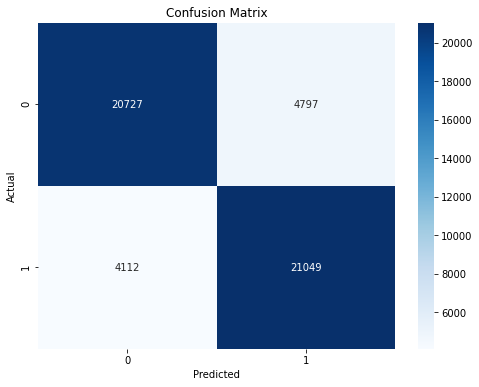

In [18]:
# Confusion Matrix
y_pred = stacking_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Save the plot as an SVG file
plt.savefig(r"/root/raman raw data/confusion_matrix.svg", format='svg')

plt.show()

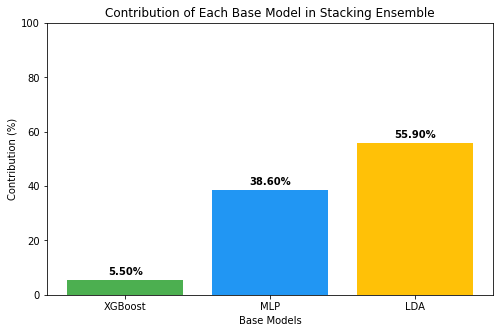

In [19]:
# Contributions
coefficients = np.abs(stacking_model.final_estimator_.coef_[0])
total = np.sum(coefficients)

percentages = (coefficients / total) * 100
model_names = ['XGBoost', 'MLP', 'LDA']

plt.figure(figsize=(8, 5))
plt.bar(model_names, percentages, color=['#4CAF50', '#2196F3', '#FFC107'])
plt.xlabel('Base Models')
plt.ylabel('Contribution (%)')
plt.title('Contribution of Each Base Model in Stacking Ensemble')
plt.ylim(0, 100)

for i, percentage in enumerate(percentages):
    plt.text(i, percentage + 2, f"{percentage:.2f}%", ha='center', fontweight='bold')

plt.show()

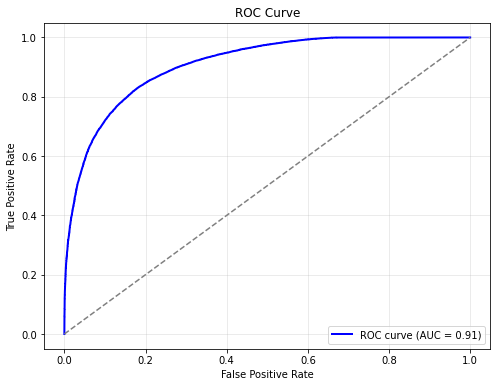

In [61]:
# ROC Curve
y_prob = stacking_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Save
joblib.dump(stacking_model, '/root/raman raw data/stacking_model.h5') #2957